In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"

pd.set_option('display.max_rows', 10000)

# EDA for EIA data

In [3]:
## Load in EIA data
eia_data = pd.read_feather('eia.feather')
## Convert `period` to datetime and `value` to numeric
eia_data['date_time'] = pd.to_datetime(eia_data['period'], format='%Y-%m-%dT%H')
eia_data['value'] = pd.to_numeric(eia_data['value'])
## Drop `period` column
eia_data.drop('period', axis=1, inplace=True)
## Print out info about data
eia_data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1757255 entries, 0 to 2254
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   respondent       1757255 non-null  object        
 1   respondent-name  1757255 non-null  object        
 2   fueltype         1757255 non-null  object        
 3   type-name        1757255 non-null  object        
 4   value            1757255 non-null  int64         
 5   value-units      1757255 non-null  object        
 6   date_time        1757255 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 107.3+ MB


In [4]:
eia_data.head()

,respondent,respondent-name,fueltype,type-name,value,value-units,date_time
0,CAL,California,COL,Coal,263,megawatthours,2024-01-01
1,CAL,California,NG,Natural Gas,12835,megawatthours,2024-01-01
2,CAL,California,NUC,Nuclear,2232,megawatthours,2024-01-01
3,CAL,California,OIL,Petroleum,46,megawatthours,2024-01-01
4,CAL,California,OTH,Other,555,megawatthours,2024-01-01


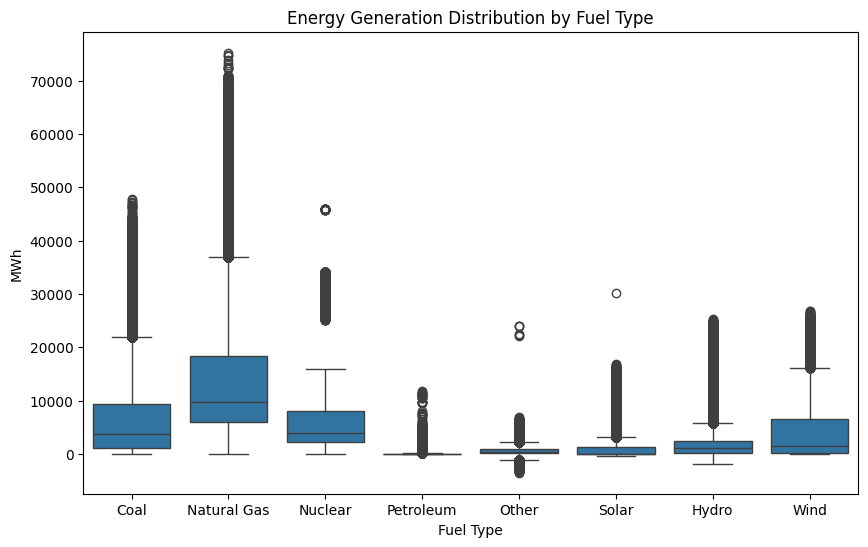

In [5]:
## Plot MWh Distribution by Fuel Type

fuel_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=eia_data, legend=False, showfliers=True)
plt.title('Energy Generation Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# fuel_dist_plt.show()
plt.savefig('../images/MWh_Fuel_type.png')

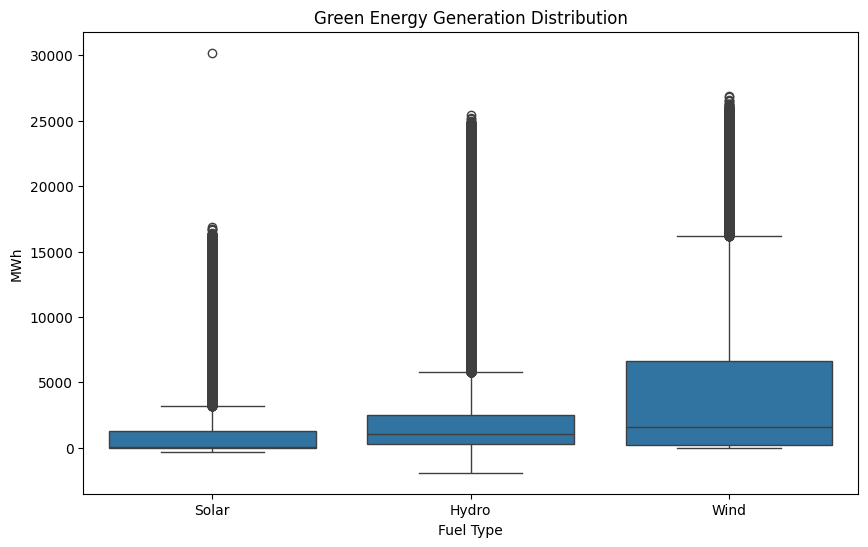

In [6]:
## Mostly curious about Solar, Hydro and Wind
green_data = eia_data[eia_data['type-name'].isin(['Solar', 'Hydro', 'Wind'])].copy()
green_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=green_data, legend=False, showfliers=True)
plt.title('Green Energy Generation Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# green_dist_plt.show()
plt.savefig('../images/MWh_Green_type.png')

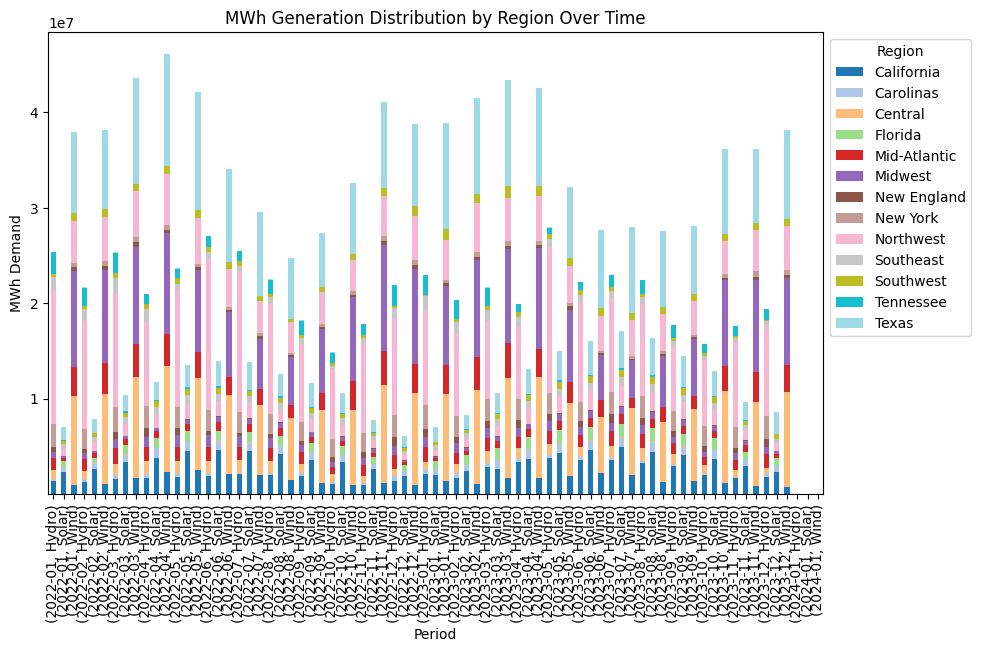

In [11]:
green_resampled = green_data.set_index('date_time').groupby(['respondent-name','type-name']).resample('MS')['value'].sum().reset_index()
green_resampled['date_time'] = green_resampled['date_time'].dt.strftime('%Y-%m')
green_resampled.head()

# Grouping and pivoting the data
grouped_data = green_resampled.groupby(['date_time', 'type-name','respondent-name']).value.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Generation Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Generation')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')

In [10]:
grouped_data

respondent-name      California  Carolinas     Central    Florida  \
date_time type-name                                                 
2022-01   Hydro       1308348.0   312265.0    830983.0    22095.0   
          Solar       2266536.0   554852.0     33294.0   609990.0   
          Wind         928898.0        0.0   9313753.0        0.0   
2022-02   Hydro       1222636.0   317356.0    800166.0    19749.0   
          Solar       2660833.0   613118.0     38457.0   496371.0   
          Wind        1058405.0        0.0   9374518.0        0.0   
2022-03   Hydro       1529939.0   494274.0   1124333.0    21568.0   
          Solar       3351064.0   760499.0     43958.0  1025753.0   
          Wind        1652381.0        0.0  10588169.0        0.0   
2022-04   Hydro       1686599.0   424068.0   1374759.0    17375.0   
          Solar       3776476.0   989946.0     53133.0  1011862.0   
          Wind        2283151.0        0.0  11141512.0        0.0   
2022-05   Hydro       1768042.0   311729.0   1303375.0    23614.0   
          Solar       4458800.0   957213.0     61147.0  1157236.0   
          Wind        2523758.0        0.0   9598434.0        0.0   
2022-06   Hydro       1857666.0   230655.0   1329923.0    17394.0   
          Solar       4587029.0   995550.0     56327.0   993434.0   
          Wind        2054204.0        0.0   8324188.0        0.0   
2022-07   Hydro       2057945.0   184418.0   1328260.0    19776.0   
          Solar       4484071.0   890762.0     63263.0  1098514.0   
          Wind        2040008.0        0.0   7329027.0        0.0   
2022-08   Hydro       1995743.0   170834.0   1232892.0    19028.0   
          Solar       4151986.0   853140.0     50184.0  1056242.0   
          Wind        1505792.0        0.0   6434427.0        0.0   
2022-09   Hydro       1908484.0   246399.0    988268.0    17717.0   
          Solar       3555337.0   805004.0     50459.0   883339.0   
          Wind        1158999.0        0.0   7650394.0        0.0   
2022-10   Hydro       1095419.0   127743.0    810452.0    12499.0   
          Solar       3307466.0   747510.0     33446.0   970849.0   
          Wind         933795.0        0.0   7884030.0        0.0   
2022-11   Hydro        964036.0   205048.0    743068.0    16241.0   
          Solar       2571530.0   560556.0     26950.0   686423.0   
          Wind        1163523.0        0.0  10266621.0        0.0   
2022-12   Hydro       1391474.0   471811.0    699386.0    23469.0   
          Solar       1854114.0   456737.0     25737.0   704182.0   
          Wind         944313.0        0.0   9585386.0        0.0   
2023-01   Hydro       2106776.0   508254.0    754934.0    21817.0   
          Solar       1973622.0   556098.0     25425.0   867109.0   
          Wind        1314305.0        0.0   9204998.0        0.0   
2023-02   Hydro       1697839.0   470601.0    985469.0    11707.0   
          Solar       2419925.0   609365.0     26526.0  1012981.0   
          Wind        1082119.0        0.0   9825926.0        0.0   
2023-03   Hydro       2849610.0   417887.0   1252277.0    24105.0   
          Solar       2659708.0   871817.0     38626.0  1288899.0   
          Wind        1626695.0        0.0  10544806.0        0.0   
2023-04   Hydro       3387470.0   429051.0    940360.0    17559.0   
          Solar       3713610.0   956320.0     56258.0  1249844.0   
          Wind        1646314.0        0.0  10628786.0        0.0   
2023-05   Hydro       3733598.0   309031.0   1131723.0    26700.0   
          Solar       4322440.0   874448.0     61117.0  1465757.0   
          Wind        1902044.0        0.0   7614173.0        0.0   
2023-06   Hydro       3568119.0   340281.0   1017934.0    19331.0   
          Solar       4652425.0   927814.0     67038.0  1355496.0   
          Wind        2179296.0        0.0   5860158.0        0.0   
2023-07   Hydro       3535972.0   219132.0   1210635.0    24911.0   
          Solar       4902364.0  1002532.0     71992.0  1318656.0  

# EDA for Demand Data

In [47]:
demand = pd.read_feather('demand.feather')
demand['sales'] = pd.to_numeric(demand['sales'])
demand.head()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region
0,2023-12,CA,California,IND,industrial,146640,17.99,582.45146,3238.52613,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,California
1,2023-12,WA,Washington,TRA,transportation,5,10.08,1.10199,10.93582,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
2,2023-12,WA,Washington,RES,residential,3340072,10.98,438.42493,3991.43173,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
3,2023-12,WA,Washington,OTH,other,None,None,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
4,2023-12,WA,Washington,IND,industrial,27971,6.1,104.54644,1712.55479,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest


In [46]:
demand.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 7343 entries, 0 to 2342
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   period            7343 non-null   object
 1   stateid           7343 non-null   object
 2   stateDescription  7343 non-null   object
 3   sectorid          7343 non-null   object
 4   sectorName        7343 non-null   object
 5   customers         6119 non-null   object
 6   price             6119 non-null   object
 7   revenue           6119 non-null   object
 8   sales             6119 non-null   object
 9   customers-units   7343 non-null   object
 10  price-units       7343 non-null   object
 11  revenue-units     7343 non-null   object
 12  sales-units       7343 non-null   object
 13  eia_region        7067 non-null   object
dtypes: object(14)
memory usage: 860.5+ KB


In [42]:
demand.sectorName.unique()

array(['industrial', 'transportation', 'residential', 'other',
       'commercial', 'all sectors'], dtype=object)

In [43]:
demand[demand['sectorName'] == 'all sectors'].head()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region
6,2023-12,WA,Washington,ALL,all sectors,3770423,9.65,808.63812,8375.63997,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
12,2023-12,VA,Virginia,ALL,all sectors,4081231,10.4,1208.82797,11626.37358,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Mid-Atlantic
18,2023-12,VT,Vermont,ALL,all sectors,385727,18.17,87.06896,479.14123,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,New England
24,2023-12,UT,Utah,ALL,all sectors,1412277,8.53,238.77143,2798.57326,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Southwest
30,2023-12,TX,Texas,ALL,all sectors,14180392,9.37,3412.78883,36417.69871,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Texas


/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_57140/3793173528.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



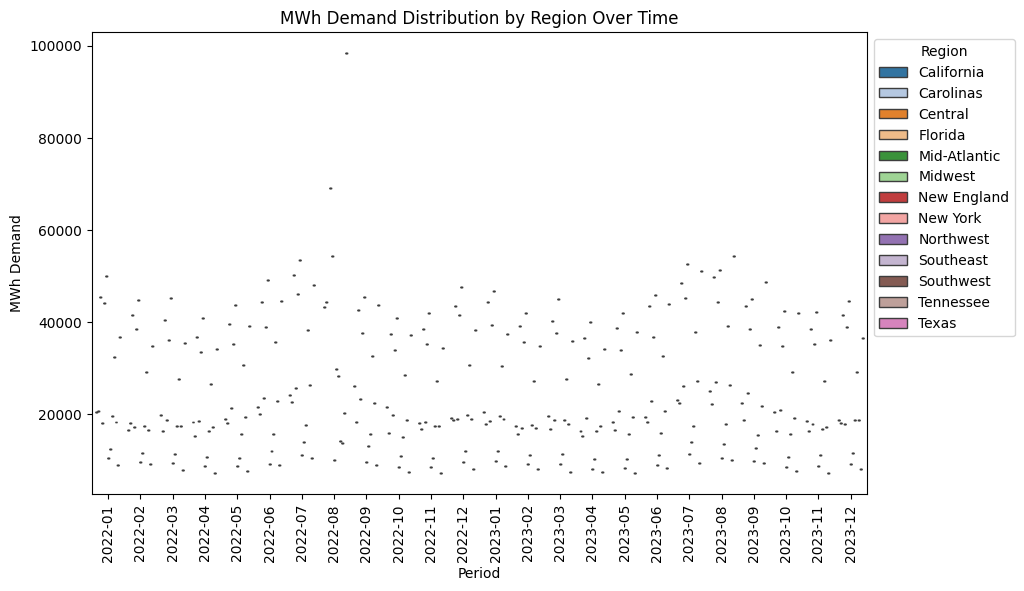

In [61]:
all_demand = demand[demand['sectorName'] == 'all sectors'].copy()
all_demand['period'] = pd.to_datetime(all_demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
all_demand_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='sales', data=all_demand.groupby(['period','eia_region']).sales.sum().reset_index(), palette='tab20', hue='eia_region')
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
all_demand_plt.show()
plt.savefig('../images/MWh_demand.png')

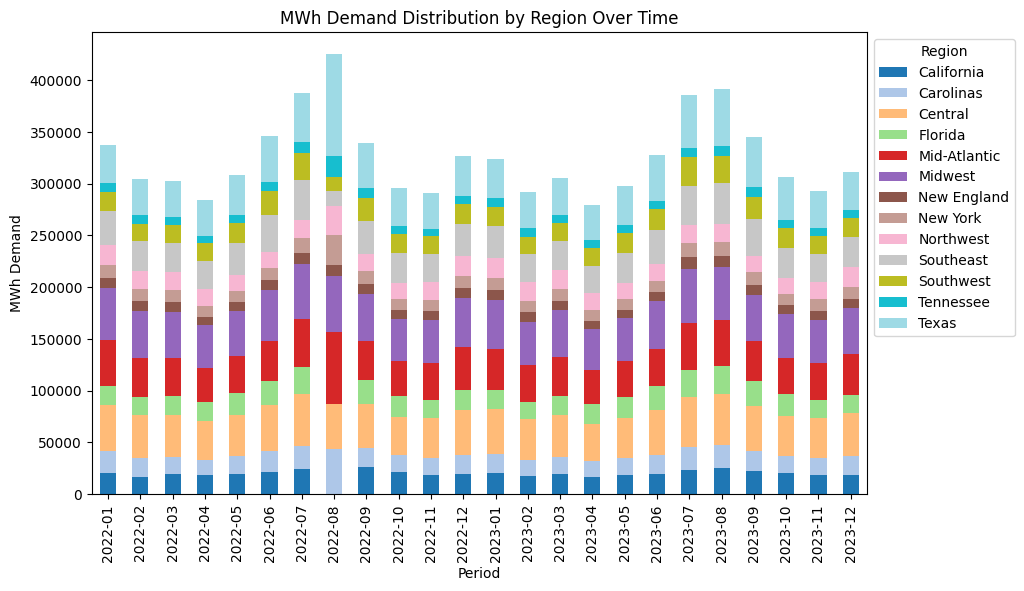

In [62]:
# Grouping and pivoting the data
grouped_data = all_demand.groupby(['period', 'eia_region']).sales.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')

# Display the plot
plt.show()

# Save the plot
fig.savefig('../images/MWh_demand2.png')